# Modeling

In [33]:
# Imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
import sklearn.model_selection as skm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
import time
import itertools

In [34]:
# Data Preparation
df = pd.read_csv('cleaned_HK_AirBnB_Data.csv')
df.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), np.log(df['price']), test_size=0.2, random_state=42)

In [36]:
# Setup Cross Validation
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [39]:
# PCR Model with PCA


scaler = StandardScaler()
pca = PCA()
linreg = LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])

pipe.fit(X_train, y_train)
print(pipe.named_steps['linreg'].coef_)


[ 3.39617649e-01 -2.03471639e-02  4.75122979e-02 -4.08054048e-02
 -1.41706910e-01  4.75799173e-02 -2.07857230e-01 -5.06760781e-02
  2.51804125e-02  1.78513188e-02 -3.06688751e-03  1.12615791e-03
 -1.79451514e-03 -9.04196868e-03  1.44134445e-02  3.22335336e-02
  2.12561286e-02 -2.07493943e-02  2.01058832e-02 -2.27957002e-02
 -6.25924524e-02  4.51228218e-02 -3.35683130e-02 -3.47419706e-02
 -1.08936877e-02 -2.28490690e-01 -2.11846823e-01  1.27059100e-01
  1.55159547e-03  5.74916655e-03  2.13361995e+11 -1.75856957e+11]


In [41]:
# Grid Search for PCA Components
param_grid = {'pca__n_components': range(1, 34)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mccao\AppData\Roaming\Python\Python311\site-pa

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 34)},
             scoring='neg_mean_squared_error')

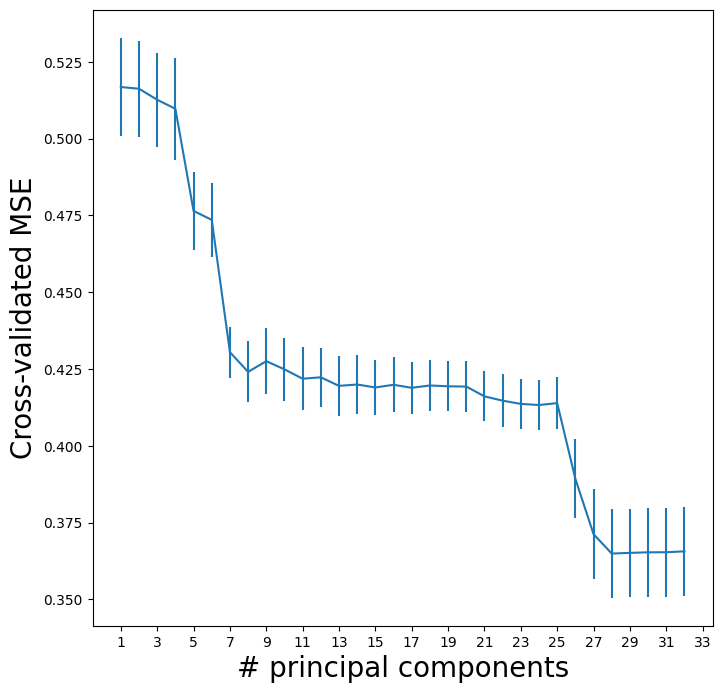

In [45]:
# Plot PCA Results
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [43]:
predictions = grid.predict(X_test)
print(mean_squared_error(y_test, predictions))

0.3042489916253458


In [28]:
# ElasticNet Model
elastic_net = ElasticNet(random_state=0)
param_grid_en = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_search_en = GridSearchCV(elastic_net, param_grid_en, cv=kfold, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train, y_train)
print("Best parameters found: ", grid_search_en.best_params_)

C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.729e+02, tolerance: 3.484e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.160e+02, tolerance: 3.571e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.0}


C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e+03, tolerance: 4.453e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [29]:
# Print MSE and Feature Importance from ElasticNet
y_pred_en = grid_search_en.predict(X_test)
print("MSE from ElasticNet: ", mean_squared_error(y_test, y_pred_en))
feature_importance_en = np.abs(grid_search_en.best_estimator_.coef_)
important_features_en = np.argsort(feature_importance_en)[::-1]
print("Most Important Features by Elastic Net Model:")
for i in important_features_en[:12]:
    print(df.columns[i], feature_importance_en[i])

MSE from ElasticNet:  0.3180977938129433
Most Important Features by Elastic Net Model:
number_of_reviews_ltm 0.3093402592803977
room_type_Private room 0.18308270013768932
room_type_Hotel room 0.11167171340778555
bathroom_count 0.09056152618943061
room_type_Shared room 0.08896387056551668
bed_count 0.07690174517037783
true_district_Sham Shui Po 0.056557687153597665
true_district_Wong Tai Sin 0.05499354224448374
true_district_Tuen Mun 0.03720202805359014
true_district_Tai Po 0.030256591887647163
true_district_Eastern 0.028187216468934167
true_district_Sha Tin 0.02695322823480757


## Gradient Boosting Model

In [30]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
import time

In [31]:
start_time = time.time()

boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001, 
                   max_depth=3, 
                   random_state=0)
boost_boston.fit(X_train, y_train)

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 27.28114151954651 seconds


In [32]:
num_estimators = np.arange(20, 401, 40)
num_depths = np.arange(1,11,2)
num_samples_per_splits = np.arange(2,11,2)


param_grid = {'n_estimators': num_estimators, 
              'max_depth': num_depths,
              'min_samples_split': num_samples_per_splits
             }

boost = GBR(learning_rate=0.02, 
            max_depth=1, 
            random_state=0)

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10) 

grid = skm.GridSearchCV(boost,
                        param_grid,
                        refit=True,
                        cv=kfold, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1) # n_jobs=-1 means use all available processors to parallelize

G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
print(grid.best_params_, np.mean((y_test - best_.predict(X_test))**2))

{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 380} 0.1517864301011409
